In [1]:
import sys
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
import astropy
import healpy as hp
from scipy.special import lpn
import fitsio as fio
import treecorr as corr

In [2]:
def getBinned(Cls, l_min, l_max, Nbins):
    dlogell = np.log10(l_max/l_min)/(Nbins-1)
    l_cen = np.logspace( np.log10(l_min), np.log10(l_max), Nbins )
    l_left = 10**(np.log10(l_cen) - 0.5*dlogell)
    l_right = 10**(np.log10(l_cen) + 0.5*dlogell)

    Cls_binned = np.zeros(Nbins)
    Cls_modect = np.zeros(Nbins)
    
    start = 0
    i = 0
    while i < Cls.shape[0] and start < Nbins:
        ell = Cls[i,0]
        if ell < l_left[start]:
            i += 1
        elif ell >= l_right[start]:
            start += 1
        else:
            
        #if ell >= l_right[start] or ell < l_left[start]:
        #    start += 1
        #    continue
        #if start >= Nbins:
        #    break
            Cls_binned[start] += Cls[i,1]
            Cls_modect[start] += 1
            i += 1
        
    for i in range(Nbins):
        Cls_binned[i] /= Cls_modect[i]
    return Cls_binned, l_cen

def smoothWF(ell, fwhm):
    ell_beam = np.sqrt(16*np.log(2))/fwhm
    return np.exp(-ell*(ell+1)/ell_beam**2)

Pl = None
def Pl_tab(itheta, ell, bin_average=True):
    global Pl
    LMAX = 50000;
    if isinstance(Pl, type(None)):
        Pl = np.zeros([20, LMAX+1])
        theta_bin_edges = np.logspace(np.log10(2.5), np.log10(250), 21)/60/180*np.pi
        
        xmin = np.cos(theta_bin_edges[:-1])
        xmax = np.cos(theta_bin_edges[1:])
        xcen = 2./3.*(theta_bin_edges[1:]**3-theta_bin_edges[:-1]**3)/\
            (theta_bin_edges[1:]**2.-theta_bin_edges[:-1]**2)
        logdt = np.log10(theta_bin_edges[-1]-theta_bin_edges[0])/20
        '''
        1./(4.*M_PI)*(Pmin[l+1]-Pmax[l+1]-Pmin[l-1]+Pmax[l-1])/(xmin[i]-xmax[i]);
        '''
        for i in range(20):
            #Pl[i] = 1/(4*np.pi)*(Pmin[1:]-Pmax[1:]-Pmin[:-1]+Pmax[:-1])/(xmin[i]-xmax[i])
            Pl[i][0] = 1/(4*np.pi)
            if bin_average:
                Pmin, dPmin = lpn(LMAX, xmin[i])
                Pmax, dPmax = lpn(LMAX, xmax[i])
                for l in range(1,LMAX):
                    Pl[i,l] = 1./(4.*np.pi)*(Pmin[l+1]-Pmax[l+1]-Pmin[l-1]+Pmax[l-1])/(xmin[i]-xmax[i])
            else:
                Pcen, dPcen = lpn(LMAX, xcen[i])
                for l in range(1,LMAX):
                    Pl[i,l] = Pcen[l]
    return Pl[itheta,ell]

Pl2 = None
def Pl2_tab(itheta, ell, bin_average=True):
    global Pl2
    LMAX = 50000;
    if isinstance(Pl2, type(None)):
        Pl2 = np.zeros([20, LMAX+1])
        theta_bin_edges = np.logspace(np.log10(2.5), np.log10(250), 21)/60/180*np.pi
        
        xmin = np.cos(theta_bin_edges[:-1])
        xmax = np.cos(theta_bin_edges[1:])
        logdt = np.log10(theta_bin_edges[-1]-theta_bin_edges[0])/20
    
        for i in range(20):
            Pmin, dPmin = lpn(LMAX, xmin[i])
            Pmax, dPmax = lpn(LMAX, xmax[i])
            '''
            Pl2[i][l] = (2.*l+1)/(4.*M_PI*l*(l+1)*(xmin[i]-xmax[i]))
        *((l+2./(2*l+1.))*(Pmin[l-1]-Pmax[l-1])
        +(2-l)*(xmin[i]*Pmin[l]-xmax[i]*Pmax[l])
        -2./(2*l+1.)*(Pmin[l+1]-Pmax[l+1]));
            '''
            for l in range(1,LMAX):
                Pl2[i,l] = (2*l+1)/(4.*np.pi*l*(l+1))*\
                ( (l+2./(2*l+1))*(Pmin[l-1]-Pmax[l-1])\
                  +(2-l)*(xmin[i]*Pmin[l]-xmax[i]*Pmax[l])\
                -2./(2*l+1)*(Pmin[l+1]-Pmax[l+1]) )/(xmin[i]-xmax[i])
            Pl2[i][0] = 1/(4*np.pi)
    return Pl2[itheta,ell]

def GaussianBeam(theta_fwhm, ell, ell_left, ell_right):
    ell_min = ell_left - 10
    ell_max = ell_right + 50
    ell_beam = np.sqrt(16.0 * np.log(2.0)) / theta_fwhm
    # Turn-On Gaussian Beam Smoothing
    if(theta_fwhm > 0.0):
        # smooth kernel
        BeamKernel = np.exp(-1.*ell*(ell+1.) / (ell_beam * ell_beam));
        # window function
        if((ell<ell_min) or (ell>ell_max)):
            window_func = 0.
        # tapering the edges
        elif((ell_min <= ell) and (ell<ell_left)):
            u = (ell - ell_min)/(ell_left - ell_min)
            window_func = u - np.sin(2*np.pi*u)/(2*np.pi)
        elif ((ell_right < ell) and (ell <= ell_max)):
            u = (ell_max - ell)/(ell_max - ell_right)
            window_func = u - np.sin(2*np.pi*u)/(2*np.pi)
        else:
            window_func = 1.0;
        BeamKernel *= window_func;
    # Turn-Off Gaussian Beam Smoothing
    else:
        BeamKernel = 1.0
    return BeamKernel

def change_coord(mapp, coord):
    npix = mapp.shape[-1]
    nside = hp.npix2nside(npix)
    ang = hp.pix2ang(nside, np.arange(npix))
    rot = hp.Rotator(coord=reversed(coord))
    new_ang = rot(*ang)
    new_pix = hp.ang2pix(nside, *new_ang)
    return mapp[..., new_pix]

In [9]:
cmb_dir = "/groups/timeifler/jiachuanxu/plancksmica"
#cmb_dir = "/Users/jiachuanxu/Workspace/CosmoLike/DESxPlanck/cmblensrec/plancksmica"
cosmolike_dir = "/home/u17/jiachuanxu/CosmoLike/DESxPlanck"
#cosmolike_dir = "/Users/jiachuanxu/Workspace/CosmoLike/DESxPlanck"
cocoa_dir = "/home/u17/jiachuanxu/cocoa/Cocoa/projects"
#cocoa_dir = "/Users/jiachuanxu/Workspace/cocoa/Cocoa/projects"

# Reference map
nlkk_MV = np.genfromtxt(cmb_dir+"/COM_Lensing_4096_R3.00/MV/nlkk.dat")
nlkk_PP = np.genfromtxt(cmb_dir+"/COM_Lensing_4096_R3.00/PP/nlkk.dat")
nlkk_TT = np.genfromtxt(cmb_dir+"/COM_Lensing_4096_R3.00/TT/nlkk.dat")
nlkk_SZdeproj = np.genfromtxt(cmb_dir+"/COM_Lensing_Szdeproj_4096_R3.00/TT/nlkk.dat")
nlkk_SZcontm = np.genfromtxt(cmb_dir+"/COM_Lensing_Sz_4096_R3.00/MV/nlkk.dat")
#nlkk_TT = np.genfromtxt(cmb_dir+"/COM_Lensing_4096_R3.00/TT/nlkk.dat")

# CMB noise adopted
noise_ref = np.genfromtxt(cosmolike_dir+"/cmblensrec/plancksmica/cmb_lmax3000.txt")

# Survey footprint mask
Nside = 1024
mask_planck = hp.pixelfunc.ud_grade(hp.read_map(cmb_dir+"/COM_Lensing_4096_R3.00/mask.fits").astype(bool), Nside)
mask_planck = change_coord(mask_planck, ['G', 'C'])
mask_DESY1_fn = "/home/u17/jiachuanxu/CosmoLike/2pt_measurements/DES_Y1A1_3x2pt_redMaGiC_MASK_HPIX4096RING.fits"
mask_DESY1 = hp.pixelfunc.ud_grade(hp.read_map(mask_DESY1_fn), Nside)


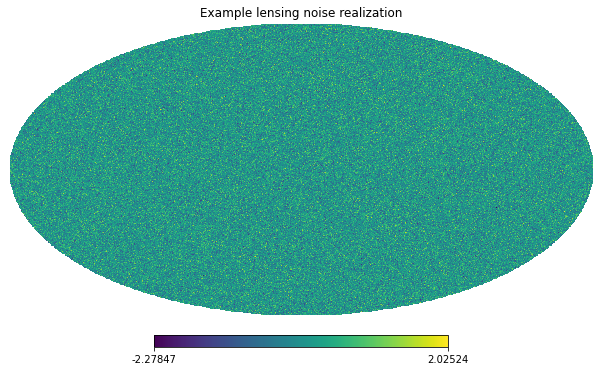

In [4]:
# check out reconstructed noise map
lmax = 4096
Nside=1024
beam_FWHM = 7/60./180.*np.pi
noise_cl = nlkk_SZdeproj[:,1].copy()
#noise_cl[nlkk_MV[:,0]>3071]=0.0
noise_map, noise_alm = hp.sphtfunc.synfast(noise_cl, Nside, lmax=lmax, alm=True, fwhm=beam_FWHM)
noise_cl_rec = hp.sphtfunc.alm2cl(noise_alm, lmax=lmax,)
hp.mollview(noise_map, title="Example lensing noise realization")

pixel resolution ~ 3.435486411817406 arcmin


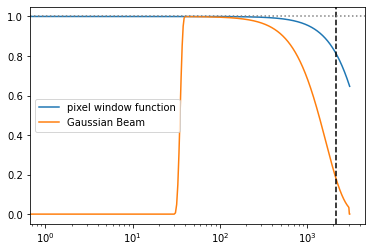

In [12]:
nside = 1024
pw = hp.sphtfunc.pixwin(nside)
ell = np.arange(3*nside)
print(f'pixel resolution ~ {hp.pixelfunc.nside2resol(nside, arcmin=True)} arcmin')

plt.semilogx(ell, pw, label='pixel window function')
plt.semilogx(ell, [GaussianBeam(7/60/180*np.pi, l, 40, 2999) for l in ell], label='Gaussian Beam')
#plt.xlim([1,3001])
plt.axvline(2*np.pi/(10/60/180*np.pi), ls='--', color='k')
plt.axhline(1, ls=':', color='grey')
plt.legend()
plt.show()

In [13]:
from scipy.stats import binned_statistic
dlogell = np.log10(3000/3)/(101-1)
l_cen = np.logspace( np.log10(3), np.log10(3000), 101 )
l_edge = 10**(np.log10(l_cen) - 0.5*dlogell)

nlkk_MV_binned = np.interp(l_cen, 
                           nlkk_MV[:,0], 
                           nlkk_MV[:,1]*smoothWF(nlkk_MV[:,0], beam_FWHM)**2 )
nlkk_Sz_binned = np.interp(l_cen, 
                           nlkk_SZcontm[:,0], 
                           nlkk_SZcontm[:,1]*smoothWF(nlkk_SZcontm[:,0], beam_FWHM)**2 )
nlkk_dp_binned = np.interp(l_cen, 
                           nlkk_SZdeproj[:,0], 
                           nlkk_SZdeproj[:,1]*smoothWF(nlkk_SZdeproj[:,0], beam_FWHM)**2 )

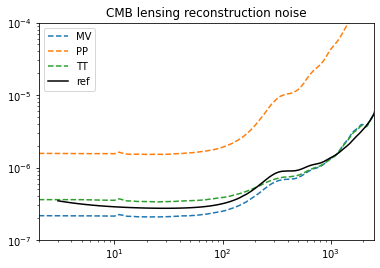

In [14]:
plt.loglog(nlkk_MV[:,0], nlkk_MV[:,1], ls='--', label='MV')
plt.loglog(nlkk_PP[:,0], nlkk_PP[:,1], ls='--', label='PP')
plt.loglog(nlkk_TT[:,0], nlkk_TT[:,1], ls='--', label='TT')
plt.loglog(noise_ref[:,0], noise_ref[:,1], label='ref', color='k', ls='-')
#plt.loglog(noise_cocoa[:,0], noise_cocoa[:,1]*noise_cocoa[:,0]*(noise_cocoa[:,0]+1)/(4), 
#           label='cocoa', color='r', ls='-.')
plt.legend()
plt.xlim([2,2500])
plt.ylim([1e-7, 1e-4])
plt.title(r"CMB lensing reconstruction noise")

plt.show()
#plt.savefig('figs/CMB_lensing_reconstruction_noise.png', dpi=300)

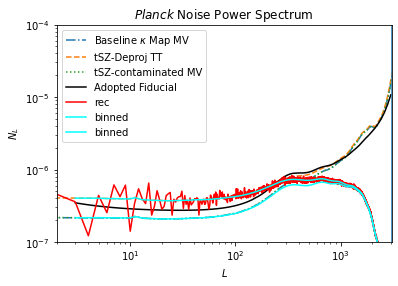

In [15]:

plt.loglog(nlkk_MV[:,0], nlkk_MV[:,1], ls='-.', label=r'Baseline $\kappa$ Map MV')
plt.loglog(nlkk_SZdeproj[:,0], nlkk_SZdeproj[:,1], ls='--', label='tSZ-Deproj TT')
plt.loglog(nlkk_SZcontm[:,0], nlkk_SZcontm[:,1], ls=':', label='tSZ-contaminated MV')
plt.loglog(noise_ref[:,0], noise_ref[:,1], label='Adopted Fiducial', color='k', ls='-')

plt.loglog(nlkk_MV[:,0], noise_cl_rec, label='rec', color='r')

#plt.loglog(l_cen, nlkk_MV_binned, color='cyan', label='binned')
plt.loglog(l_cen, nlkk_Sz_binned, color='cyan', label='binned')
plt.loglog(l_cen, nlkk_dp_binned, color='cyan', label='binned')

plt.legend(loc='upper left')
plt.xlim([2,3049])
#plt.xlim([2,5096])
plt.ylim([1e-7, 1e-4])
plt.title(r'$Planck$ Noise Power Spectrum')
plt.xlabel(r'$L$')
plt.ylabel(r'$N_L$')
#plt.savefig("figs/CMBNoisePowerSpectrum.png", dpi=300)
plt.axvline(360*60/7)
plt.show()

## real space shot noise term related with Planck lensing convergence field

Note that by definition, in the spherical harmonics expansion, the "power spectrum" is definied as 
$$C(l) = \frac{1}{2l+1}\sum_m \langle \tilde{X}_{lm}\tilde{X}^*_{lm}\rangle$$

The probes related are


$$w_{g\kappa_\mathrm{CMB}^i}(\theta)=\sum_l\frac{2\ell+1}{4\pi}F(l)\bar{P_l}(\mathrm{cos}\theta)C^{\delta_g^i\kappa_\mathrm{CMB}}(l)$$

$$w_{s\kappa_\mathrm{CMB}^i}(\theta)=\sum_l\frac{2\ell+1}{4\pi l(l+1)}F(l)\bar{P_l^2}(\mathrm{cos}\theta)C^{\kappa_g^i\kappa_\mathrm{CMB}}(l)$$

The shot noise term for Cov($w_{g\kappa_\mathrm{CMB}}^i(\theta_1)$; $w_{g\kappa_\mathrm{CMB}}^j(\theta_2)$) is 

$$\sum_{l_1}\frac{2l_1+1}{4\pi}F(l_1)\bar{P_{l_1}}(\mathrm{cos}\theta_1) \sum_{l_2}\frac{2l_2+1}{4\pi}F(l_2)\bar{P_{l_2}}(\mathrm{cos}\theta_2)\times\{\frac{4\pi\delta_{l_1l_2}\delta_{ij}}{\Omega_s(2l_1+1)}N_{\kappa_\mathrm{CMB}}(l)\frac{1}{n_g^i}\}$$

And Cov($w_{s\kappa_\mathrm{CMB}}^i(\theta_1)$; $w_{s\kappa_\mathrm{CMB}}^j(\theta_2)$):

$$\sum_{l_1}\frac{2l_1+1}{4\pi l_1(l_1+1)}F(l_1)\bar{P_{l_1}^2}(\mathrm{cos}\theta_1) \sum_{l_2}\frac{2l_2+1}{4\pi l_1(l_1+1)}F(l_2)\bar{P_{l_2}^2}(\mathrm{cos}\theta_2)\times\{\frac{4\pi\delta_{l_1l_2}\delta_{ij}}{\Omega_s(2l_1+1)}N_{\kappa_\mathrm{CMB}}(l)\frac{\sigma_\epsilon^2}{2n_s^i}\}$$

In [16]:
# assume the lens galaxy bins i=j=1
# get theta bins
theta_bin_edges = np.logspace(np.log10(2.5), np.log10(250), 21)
theta_bin_center= 2./3.*(theta_bin_edges[1:]**3-theta_bin_edges[:-1]**3)/\
    (theta_bin_edges[1:]**2.-theta_bin_edges[:-1]**2)

cov_G_gkgk_NN = np.zeros([20,20])
for i in range(20):
    for j in range(20):
        theta_i = theta_bin_center[i]
        theta_j = theta_bin_center[j]
        for l in range(4097):
            # get bin-averaged Legendre Polynomials
            func_1 = Pl_tab(i,l,bin_average=False)
            func_2 = Pl_tab(j,l,bin_average=False)
            # get Gaussian beam kernel (and healpix pixel window function)
            beam = GaussianBeam(7/60/180*np.pi, l, 40, 2999)
            #beam = 1
            # get CMB lensing convergence reconstruction noise power spectrum
            Nl = nlkk_MV[l,1]
            #Nl = 1
            # calculate the 2d NN-component covmat
            cov_G_gkgk_NN[i,j] += beam*func_1*beam*func_2*(2*l+1)/(4*np.pi*4*np.pi*0.637)*Nl/(2*(60*180/np.pi)**2)
# test whether off-diagonal components are significant.

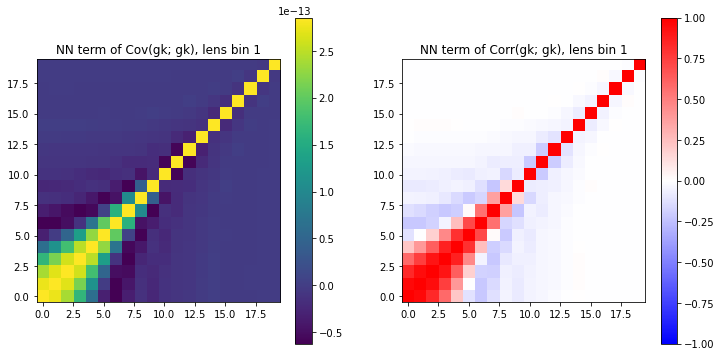

In [17]:
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

cor_G_gkgk_NN = correlation_from_covariance(cov_G_gkgk_NN)

fig, axes = plt.subplots(1,2, figsize=(12,6))

cb = axes[0].imshow(cov_G_gkgk_NN, origin='lower')
plt.colorbar(cb, ax=axes[0])
axes[0].set(title="NN term of Cov(gk; gk), lens bin 1")

cb = axes[1].imshow(cor_G_gkgk_NN, origin='lower', cmap='bwr', vmin=-1,vmax=1)
plt.colorbar(cb, ax=axes[1])
axes[1].set(title="NN term of Corr(gk; gk), lens bin 1")

plt.show()

In [41]:
np.savetxt("../cmblensrec/plancksmica/cmb_ref_smoothed_7arcmin.txt", 
           np.c_[l_cen, nlkk_MV_binned], fmt='%.15e %.15e')
np.savetxt("../cmblensrec/plancksmica/cmb_tSZ_contaminated_smoothed_7arcmin.txt", 
           np.c_[l_cen, nlkk_Sz_binned], fmt='%.15e %.15e')
np.savetxt("../cmblensrec/plancksmica/cmb_tSZ_deprojected_smoothed_7arcmin.txt", 
           np.c_[l_cen, nlkk_dp_binned], fmt='%.15e %.15e')

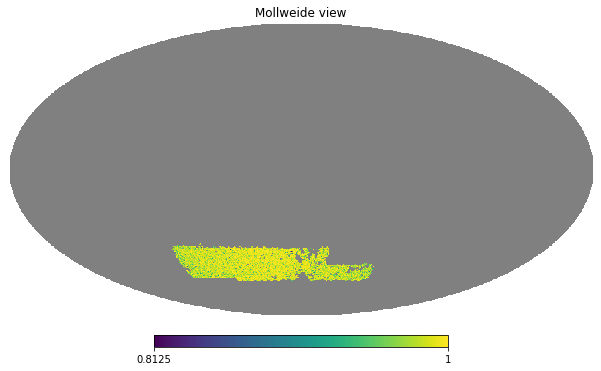

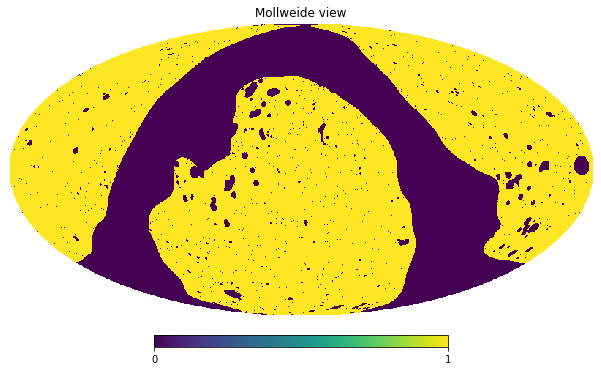

In [10]:
# qualitative study of the survey footprint
# DES Y1 footprint, Nside = 1024,
hp.mollview(mask_DESY1, )
# Planck footprint, Nside = 1024, 
hp.mollview(mask_planck)

(50331648,)